<a href="https://colab.research.google.com/github/joshtburdick/misc/blob/master/plog/PGMax_Sudoku.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solving Sudoku using [PGMax](https://github.com/google-deepmind/PGMax)

Trying to use the PGMax library, to solve *tiny* Sudoku problems. This is largely based on the [Ising model](https://colab.research.google.com/github/deepmind/PGMax/blob/master/examples/ising_model.ipynb#scrollTo=uBbZ9rmwswjx).

In [1]:
# %pip install pgmax
# from Ising example:
# Uncomment this block if running on colab.research.google.com
!pip install git+https://github.com/deepmind/PGMax.git


  Cloning https://github.com/deepmind/PGMax.git to /tmp/pip-req-build-j0y83bwt
  Running command git clone --filter=blob:none --quiet https://github.com/deepmind/PGMax.git /tmp/pip-req-build-j0y83bwt
  Resolved https://github.com/deepmind/PGMax.git to commit 741d532bb4e08f89d1bb86c8e272d913b48aa262
  Preparing metadata (setup.py) ... done


In [2]:
import itertools

import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pgmax
from pgmax import fgraph, fgroup, infer, vgroup

First, we make the grid of variables.

In [3]:
n = 4
variables = vgroup.NDVarArray(num_states=n, shape=(n, n))
variables

NDVarArray(shape=(4, 4), num_states=4, _hash=3709777776000000000)

Next, we create the factor graph.

In [4]:
# Initialize the factor graph
fg = fgraph.FactorGraph(variable_groups=variables)
fg

FactorGraph(variable_groups=[NDVarArray(shape=(4, 4), num_states=4, _hash=3709777776000000000)])

We'll use an EnumFactorGroup to list the valid Sudoku configurations (in which all the numbers in a row/column/block are different).

In [5]:
all_different = np.array(list(itertools.permutations(range(n))))
all_different

array([[0, 1, 2, 3],
       [0, 1, 3, 2],
       [0, 2, 1, 3],
       [0, 2, 3, 1],
       [0, 3, 1, 2],
       [0, 3, 2, 1],
       [1, 0, 2, 3],
       [1, 0, 3, 2],
       [1, 2, 0, 3],
       [1, 2, 3, 0],
       [1, 3, 0, 2],
       [1, 3, 2, 0],
       [2, 0, 1, 3],
       [2, 0, 3, 1],
       [2, 1, 0, 3],
       [2, 1, 3, 0],
       [2, 3, 0, 1],
       [2, 3, 1, 0],
       [3, 0, 1, 2],
       [3, 0, 2, 1],
       [3, 1, 0, 2],
       [3, 1, 2, 0],
       [3, 2, 0, 1],
       [3, 2, 1, 0]])

Now, we can add the factors.

In [6]:
# Create the pairwise factor group
variables_for_factors = []

# Add factors for rows
for row in range(n):
    variables_for_factors.append([variables[row, col] for col in range(n)])

# Add factors for columns
for col in range(n):
    variables_for_factors.append([variables[row, col] for row in range(n)])

# Add factors for 2x2 blocks
for block_row in range(0, n, 2):
    for block_col in range(0, n, 2):
        block_variables = []
        for row in range(block_row, block_row + 2):
            for col in range(block_col, block_col + 2):
                block_variables.append(variables[row, col])
        variables_for_factors.append(block_variables)

factor_group = pgmax.fgroup.EnumFactorGroup(
    variables_for_factors=variables_for_factors,
    factor_configs=all_different
)
# Add the factors to the factor graph
fg.add_factors(factor_group)
fg

FactorGraph(variable_groups=[NDVarArray(shape=(4, 4), num_states=4, _hash=3709777776000000000)])

In [7]:
bp = infer.build_inferer(fg.bp_state, backend="bp")

We now run this.

In [8]:
rng = jax.random.PRNGKey(0)
evidence_updates={variables: jax.random.gumbel(rng, shape=(n, n, n))}

# Run MAP inference
inferer_arrays = bp.init(evidence_updates=evidence_updates)
# inferer_arrays = bp.init()
inferer_arrays, msgs_deltas = bp.run_with_diffs(inferer_arrays, num_iters=3000, temperature=0)

# Compute the beliefs
beliefs = bp.get_beliefs(inferer_arrays)

We try using the same code from the Ising model, to plot this...

/usr/local/lib/python3.12/dist-packages/jax/_src/ops/scatter.py:93: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=bool with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


The energy of the decoding is -20.109865


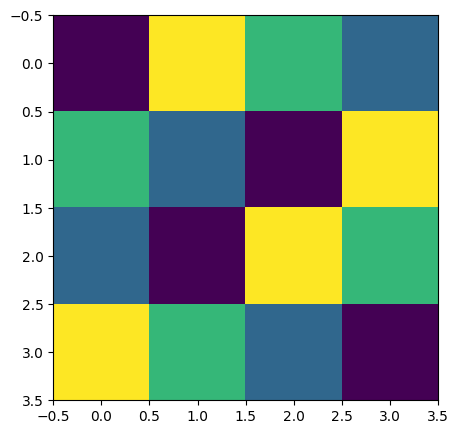

In [9]:
# Get the MAP states
map_states = infer.decode_map_states(beliefs)

# Compute the energy of the decoding
decoding_energy = (
    infer.compute_energy(fg.bp_state, inferer_arrays, map_states)[0]
)
print("The energy of the decoding is", decoding_energy)

# Plot the image
img = map_states[variables]
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(img)

... which looks like a valid Sudoku board. Woot!

To actually solve a Sudoku instance, we'd need to add factors, fixing some numbers in the grid.